# ADA 2018 -  “Happiness” Share it through music.

#### Andres Montero, Ariel Alba, Diego Iriarte




This project aims to find the relationships between tweets and music, specifically we focus on tweets which reflect a positive sentiment or mood and we'll relate them to the kind of music those people listen to. We believe that music preferences vary depending on people's mood, so we can detect what kind of music people tend to listen to when they are feeling happy or posting tweets with positive sentiment, which in our case are equivalent.
For it, we'll work with two datasets:
* FMA: A Dataset For Music Analysis
* Sentiment140 dataset with 1.6 million tweets

Tweets dataset is a labeled set, indicating whether each tweet has a positive sentiment or not.
In order to define whether the proposed idea is feasible or not, we follow these steps:

**A)** Preprocessing and analyzing FMA dataset. Gather the data that will be used, the dataset is very extense and we must focus on the data that will be used for our study. We clean the data, define the type of variables, normalize them and deal with missing values. From the cleaned data, we get some statistical information of the dataset, such as most listened songs, albums and we try to find some relationships between some information of the dataset such as: danceability, energy, number of times listened, location and others.

**B)** Loading and analyzing of Sentiment140 dataset. We will only focus on tweets which are labeled as positive sentiment and the approach. The dataset contains few information about the tweets such as date, sentiment, userID and tweet, and is limited to tweets of yar 2009. Before doing any further preprocessing of such dataset we decided to check the possible relationships that we could find with FMA dataset.


**C)** Find relationships between both datasets. It is important to identify whether the idea of the project is feasible or not. For the idea to be feasible, we need to find a considerable number of positive tweets which are somehow related to music or songs. To measure this relationships our approach is the following:
* Count how many tweets link to a song link
* Count how many tweets explicitly say spotify on it.
* Find words related to music contained in the tweets (may be a difficult task)


**D)** In case, our two first approaches to find the relationships between both datasets don't succeed, we may not be able to try with the third one due to time contraints and task difficulty. If thi is the scenario, the project scope will be reduced and will mostly focus on the FMA dataset and a specific event in the past years which may caused an impact on music production and preferences. Such scenario will be defined according to the insights found in part A.

In [1]:
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import os.path
import ast
import seaborn as sns

from helpers import *
from datetime import datetime, date, time
from scipy import stats

%load_ext autoreload
%autoreload 2


### A) Preprocessing and Analyzing FMA Dataset

First part consists of loading the data that is needed for the analysis, cleaning and storing them in dataFrames so we can further work with them.

First, we will define some constants and paths that will help us later.

In [2]:
# Constants
DATA_DIR = './data/'
MUSIC_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                                  file='fma_metadata')
PKL_DIR = '{dir}{file}/'.format(dir=DATA_DIR, 
                               file='pkl')

# True if we want to to execute the clean phase and to force 
# saving the cleaned file
CLEAN_PHASE = True
DEBUG = True


In [3]:
if CLEAN_PHASE:
    echonest_path = '{dir}{file}'.format(dir=MUSIC_DIR, 
                                         file='echonest.csv')
    features_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                         file='features.csv')
    genres_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                       file='genres.csv')
    tracks_path = '{dir}{file}'.format(dir=MUSIC_DIR,
                                       file='tracks.csv')
    

By looking at the FMA dataset we find out that metadata csv file is full of unnecesary information for our analysis.

Thus, we define which variables, type of variables and name of columns we are going to extract from the FMA csv files.

In [4]:
if CLEAN_PHASE:
    # Load datasets into pandas dataframes
    echonest_col_names=['track_id', 'danceability', 'energy',
                        'valence', 'artist_latitude',
                        'artist_longitude', 'artist_name',
                        'artist_discovery', 'artist_family',
                        'artist_hotness', 'song_currency', 
                        'song_hotness']
    
    echonest_dtypes = {'track_id': int, 'danceability': float, 
                       'energy': float, 'valence': float,
                       'artist_latitude': float, 'artist_longitude': float,
                       'artist_name': str, 'artist_discovery': float, 
                       'artist_family': float, 'artist_hotness': float,
                       'song_currency': float, 'song_hotness': float}
    
    echonest_df = pd.read_csv(echonest_path, names=echonest_col_names,
                              header=3, dtype=echonest_dtypes, 
                              usecols=[0, 2, 3, 8, 11, 13, 14,
                                       21, 22, 23, 24, 25])

    genres_dtypes = {'genre_id': int, '#tracks': int, 
                     'parent': int, 'top_level': int}
    
    genres_df = pd.read_csv(genres_path, dtype=genres_dtypes)
    
    track_col_names = ['track_id', 'album_date_created',
                       'album_date_released', 'album_id',
                       'album_listens', 'album_title', 
                       'artist_id', 'artist_latitude',
                       'artist_longitude', 'artist_name',
                       'track_duration', 'track_genre_top',
                       'track_genres_all', 'track_language', 
                       'track_listens', 'track_tags', 
                       'track_title']

    tracks_dtypes = {'track_id': int, 'album_date_created': str,
                     'album_date_released': str, 
                     'album_id': int, 'album_listens': int, 
                     'album_title': str, 'artist_id': int,
                     'artist_latitude': float, 'artist_longitude': float,
                     'artist_name': str, 'track_duration': int, 
                     'track_genre_top': str, 'track_genres_all': str, 
                     'track_language': str, 'track_listens': int,
                     'track_tags': str, 'track_title': str}

    tracks_df = pd.read_csv(tracks_path, names=track_col_names,
                            header=2, usecols=[0, 2, 3, 6, 8, 11,
                                               21, 22, 24, 26, 38, 
                                               40, 41, 45, 47, 51,
                                               52])


Right now, we have 3 dataframes: echonest, tracks and genres which makes reference to the csv files.

Now, it is time to clean data!!! And have some information in a more suitable represetation for further analysis.

First we start cleaning tracks dataframe.

In [5]:
# Tracks clean phase
if CLEAN_PHASE:
    # Transforms str to datetime
    tracks_df['album_date_released'] = pd.to_datetime( \
                                            tracks_df['album_date_released'])
    tracks_df['album_date_created'] = pd.to_datetime( \
                                            tracks_df['album_date_created'])
    # Transform str to list
    tracks_df['track_tags'] = tracks_df['track_tags'] \
                                .apply(lambda x: ast.literal_eval(x))
    tracks_df['track_genres_all'] = tracks_df['track_genres_all'] \
                                .apply(lambda x: ast.literal_eval(x))


We realize that the tracks dataframe containst also information about artists and albums and echonest has info for each track , thus, to have a better organization and not have redundacy, we joined tracks and echonest. Then the joined table was split on 3 new dataframes: tracks, albums and artists.

In [6]:
if CLEAN_PHASE:
    # Normalize dataframes to take out redundancy
    
    # Join echonist data to tracks
    echo_tracks = echonest_df.merge(tracks_df, left_on='track_id', 
                                    right_on='track_id', how='outer')
    
    print(len(echo_tracks))
     
    # Select main columns to create new df
    artists_df = echo_tracks[['artist_id', 'artist_name_x',
                              'artist_latitude_x', 'artist_longitude_x', 
                              'artist_discovery', 'artist_family', 
                              'artist_hotness', 'artist_latitude_y',
                              'artist_longitude_y', 'artist_name_y']].copy()

    albums_df = echo_tracks[['album_id', 'album_date_created',
                             'album_date_released', 'album_title',
                             'album_listens']].copy()
    
    tracks_df = echo_tracks[['track_id', 'track_title', 
                             'track_duration', 'artist_id', 
                             'album_id', 'track_genre_top',
                             'track_genres_all','track_language',
                             'track_listens', 'track_tags',
                             'danceability', 'energy',
                             'valence', 'song_currency',
                             'song_hotness']].copy()
    
    # Drop duplicates
    artists_df = artists_df.drop_duplicates('artist_id')
    albums_df = albums_df.drop_duplicates('album_id')
    
    # Reset Index
    artists_df = artists_df.reset_index(drop=True)
    albums_df = albums_df.reset_index(drop=True)
    
    # Clean listen count
    albums_df['album_listens'] = albums_df['album_listens'] \
                                    .apply(lambda x : neg_to_zero(x))
    
    tracks_df['track_listens'] = tracks_df['track_listens'] \
                                    .apply(lambda x : neg_to_zero(x))
    
    # Artist name different on echonest and FullMusicArchive
    if DEBUG:
        name_comp = not_eq_ign_case(artists_df['artist_name_x'],
                                    artists_df['artist_name_y'])
        artist_name_diff = artists_df[name_comp]
        
        print('# Different artist names: {}\n' \
                  .format(len(artist_name_diff)))

        print('Example:\n{}'.format(artist_name_diff[['artist_name_x',
                                                      'artist_name_y']].head(3)))


106574
# Different artist names: 13797

Example:
                        artist_name_x                    artist_name_y
2   Alec K. Redfearn and the Eyesores  Alec K. Redfearn & the Eyesores
26                      From Quagmire                        Dora Bleu
31                     Marc A. Pullen                          Fanatic


Finally we have 4 main datasets: genres, artists, albums and tracks.

FMA dataset (https://lts2.epfl.ch/datasets/fma/) was gathered by joining a lot of information of many music API services like Echonest(now Spotify), LastFM, MusicBrainz and others more, thus, there are some columns that have data redundacy.

In [7]:
# Artist location different on echonest and FullMusicArchive
if DEBUG and CLEAN_PHASE:
    lat_comp = artists_df['artist_latitude_x'] != artists_df['artist_latitude_y']
    long_comp = artists_df['artist_longitude_x'] != artists_df['artist_longitude_y']
    latlong_comp = lat_comp | long_comp
    latlong_diff = artists_df[latlong_comp]

    print('# Different Lat Long values: {}\n' \
              .format(len(latlong_diff)))

    print('Example:\n{}'.format(artist_name_diff[['artist_latitude_x',
                                                  'artist_latitude_y',
                                                  'artist_longitude_x',
                                                  'artist_longitude_y']].head(3)))

# Different Lat Long values: 16339

Example:
    artist_latitude_x  artist_latitude_y  artist_longitude_x  \
2             41.8239          41.823989            -71.4120   
26                NaN                NaN                 NaN   
31            40.7978                NaN            -81.3716   

    artist_longitude_y  
2           -71.412834  
26                 NaN  
31                 NaN  


Also there is some spatial information encoded on certain columns, to handle them, we used a service to retrieve the exact location (Country, city, state).

In [8]:
if CLEAN_PHASE:
    # Getting city, state, country from artist longitude and latitude
    cities=[]
    states=[]
    countries=[]
    
    for i in range (0, len(artists_df)):
        if np.isnan(artists_df.artist_latitude_y[i]):
            city = np.nan
            state = np.nan
            country = np.nan
        else:
            coordinates = (artists_df.artist_latitude_y[i], 
                           artists_df.artist_longitude_y[i])
            results = rg.search(coordinates, mode=1)
            city = results[0]['name']
            state = results[0]['admin1']
            country = results[0]['cc']
        
        cities.append(city)
        states.append(state)
        countries.append(country)
    
    artists_df.insert(loc=5, column='city', 
                      value=pd.Series(cities))
    artists_df.insert(loc=6, column='state',
                      value=pd.Series(states))
    artists_df.insert(loc=7, column='country', 
                      value=pd.Series(countries))
    

Loading formatted geocoded file...


Finally, after all preprocessing steps, we can save the information to be used for our analysis.

In [9]:
# Read  and wirte files depending on the existance of own path
echonest_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                        file='echonest_df.pkl')
genres_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='genres_df.pkl')
albums_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='albums_df.pkl')
artists_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                     file='artists_df.pkl')
tracks_df_path = '{dir}{file}'.format(dir=PKL_DIR, 
                                      file='tracks_df.pkl')

if CLEAN_PHASE:
    genres_df.to_pickle(genres_df_path)
elif os.path.exists(echonest_df_path):
    genres_df = pd.read_pickle(genres_df_path)
else:
    print('There is no genres pandas data')
    
if CLEAN_PHASE:
    albums_df.to_pickle(albums_df_path)
elif os.path.exists(albums_df_path):
    albums_df = pd.read_pickle(albums_df_path)
else:
    print('There is no albums pandas data')
    
if CLEAN_PHASE:
    artists_df.to_pickle(artists_df_path)
elif os.path.exists(artists_df_path):
    artists_df = pd.read_pickle(artists_df_path)
else:
    print('There is no albums pandas data')
    
if CLEAN_PHASE:
    tracks_df.to_pickle(tracks_df_path)
elif os.path.exists(tracks_df_path):
    tracks_df = pd.read_pickle(tracks_df_path)
else:
    print('There is no albums tracks data')
    

We identify some statistics on all dataframes, like the missing values after preprocessing, taking echonest as one dataframe, just for analysis.

In [10]:
print('Artists size: {}'.format(len(artists_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(artists_df.isna().sum(axis=0)))
artists_df.head()


Artists size: 16341

NaN count by column:
artist_id                 0
artist_name_x         13465
artist_latitude_x     14338
artist_longitude_x    14338
artist_discovery      13465
city                  12505
state                 12505
country               12505
artist_family         13465
artist_hotness        13465
artist_latitude_y     12505
artist_longitude_y    12505
artist_name_y             0
dtype: int64


,artist_id,artist_name_x,artist_latitude_x,artist_longitude_x,artist_discovery,city,state,country,artist_family,artist_hotness,artist_latitude_y,artist_longitude_y,artist_name_y
0,1,AWOL,32.6783,-83.2230,0.388990,Lakehurst,New Jersey,US,0.386740,0.406370,40.058324,-74.405661,AWOL
1,6,Kurt Vile,39.9523,-75.1624,0.557339,NaN,NaN,NaN,0.614272,0.798387,NaN,NaN,Kurt Vile
2,54,Alec K. Redfearn and the Eyesores,41.8239,-71.4120,0.388923,Providence,Rhode Island,US,0.330784,0.406300,41.823989,-71.412834,Alec K. Redfearn & the Eyesores
3,56,Amoebic Ensemble,41.8239,-71.4120,0.252381,Providence,Rhode Island,US,0.238153,0.263657,41.823989,-71.412834,Amoebic Ensemble
4,60,Arc and Sender,NaN,NaN,0.262717,Philadelphia,Pennsylvania,US,0.173315,0.274455,39.952335,-75.163789,Arc and Sender


In [11]:
print('Albums size: {}'.format(len(albums_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(albums_df.isna().sum(axis=0)))
albums_df.head()


Albums size: 14854

NaN count by column:
album_id                  0
album_date_created      459
album_date_released    5404
album_title               1
album_listens             0
dtype: int64


,album_id,album_date_created,album_date_released,album_title,album_listens
0,1,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
1,6,2008-11-26 01:45:08,2008-02-06,Constant Hitmaker,47632.0
2,60,2008-11-26 01:49:57,2009-01-16,Every Man For Himself,1304.0
3,61,2008-11-26 01:49:59,2007-05-22,The Blind Spot,1300.0
4,62,2008-11-26 01:50:03,2005-01-25,The Quiet Room,845.0


In [12]:
print('Echonest size: {}'.format(len(echonest_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(echonest_df.isna().sum(axis=0)))
echonest_df.head()


Echonest size: 13129

NaN count by column:
track_id               0
danceability           0
energy                 0
valence                0
artist_latitude     3359
artist_longitude    3359
artist_name            0
artist_discovery       0
artist_family          0
artist_hotness         0
song_currency          0
song_hotness           0
dtype: int64


,track_id,danceability,energy,valence,artist_latitude,artist_longitude,artist_name,artist_discovery,artist_family,artist_hotness,song_currency,song_hotness
0,2,0.675894,0.634476,0.576661,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
1,3,0.528643,0.817461,0.269240,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
2,5,0.745566,0.701470,0.621661,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000
3,10,0.658179,0.924525,0.963590,39.9523,-75.1624,Kurt Vile,0.557339,0.614272,0.798387,0.005158,0.354516
4,134,0.513238,0.560410,0.894072,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,0.000000,0.000000


In [13]:
print('Genres size: {}'.format(len(genres_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(genres_df.isna().sum(axis=0)))
genres_df.head()


Genres size: 163

NaN count by column:
genre_id     0
#tracks      0
parent       0
title        0
top_level    0
dtype: int64


,genre_id,#tracks,parent,title,top_level
0,1,8693,38,Avant-Garde,38
1,2,5271,0,International,2
2,3,1752,0,Blues,3
3,4,4126,0,Jazz,4
4,5,4106,0,Classical,5


In [14]:
print('Tracks size: {}'.format(len(tracks_df)))
if DEBUG: print('\nNaN count by column:\n{}' \
                .format(tracks_df.isna().sum(axis=0)))
tracks_df.head()


Tracks size: 106574

NaN count by column:
track_id                0
track_title             1
track_duration          0
artist_id               0
album_id                0
track_genre_top     56976
track_genres_all        0
track_language      91550
track_listens           0
track_tags              0
danceability        93445
energy              93445
valence             93445
song_currency       93445
song_hotness        93445
dtype: int64


,track_id,track_title,track_duration,artist_id,album_id,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability,energy,valence,song_currency,song_hotness
0,2,Food,168,1,1,Hip-Hop,[21],en,1293.0,[],0.675894,0.634476,0.576661,0.000000,0.000000
1,3,Electric Ave,237,1,1,Hip-Hop,[21],en,514.0,[],0.528643,0.817461,0.269240,0.000000,0.000000
2,5,This World,206,1,1,Hip-Hop,[21],en,1151.0,[],0.745566,0.701470,0.621661,0.000000,0.000000
3,10,Freeway,161,6,6,Pop,[10],en,50135.0,[],0.658179,0.924525,0.963590,0.005158,0.354516
4,134,Street Music,207,1,1,Hip-Hop,[21],en,943.0,[],0.513238,0.560410,0.894072,0.000000,0.000000


#### First we will see the top 10 countries were the music is produced.

In [15]:
#Merge data to have the entire data frame
tracks_echonest = echonest_df.merge(tracks_df, left_on='track_id', 
                                    right_on='track_id', how='right')
tracks_echonest.head()


,track_id,danceability_x,energy_x,valence_x,artist_latitude,artist_longitude,artist_name,artist_discovery,artist_family,artist_hotness,...,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability_y,energy_y,valence_y,song_currency_y,song_hotness_y
0,2,0.675894,0.634476,0.576661,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,...,Hip-Hop,[21],en,1293.0,[],0.675894,0.634476,0.576661,0.000000,0.000000
1,3,0.528643,0.817461,0.269240,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,...,Hip-Hop,[21],en,514.0,[],0.528643,0.817461,0.269240,0.000000,0.000000
2,5,0.745566,0.701470,0.621661,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,...,Hip-Hop,[21],en,1151.0,[],0.745566,0.701470,0.621661,0.000000,0.000000
3,10,0.658179,0.924525,0.963590,39.9523,-75.1624,Kurt Vile,0.557339,0.614272,0.798387,...,Pop,[10],en,50135.0,[],0.658179,0.924525,0.963590,0.005158,0.354516
4,134,0.513238,0.560410,0.894072,32.6783,-83.2230,AWOL,0.388990,0.386740,0.406370,...,Hip-Hop,[21],en,943.0,[],0.513238,0.560410,0.894072,0.000000,0.000000


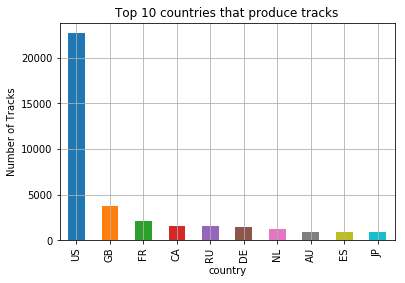

In [16]:
track_artist = tracks_df.merge(artists_df, left_on='artist_id', 
                               right_on='artist_id')
country_grouped = track_artist.groupby(track_artist['country']).size()
country_top10 = country_grouped.sort_values(ascending=False) \
                                     .head(10)
country_top10.plot(kind='bar', 
                   title="Top 10 countries that produce tracks")
plt.ylabel('Number of Tracks')
plt.grid()


#### Top 10 albums

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

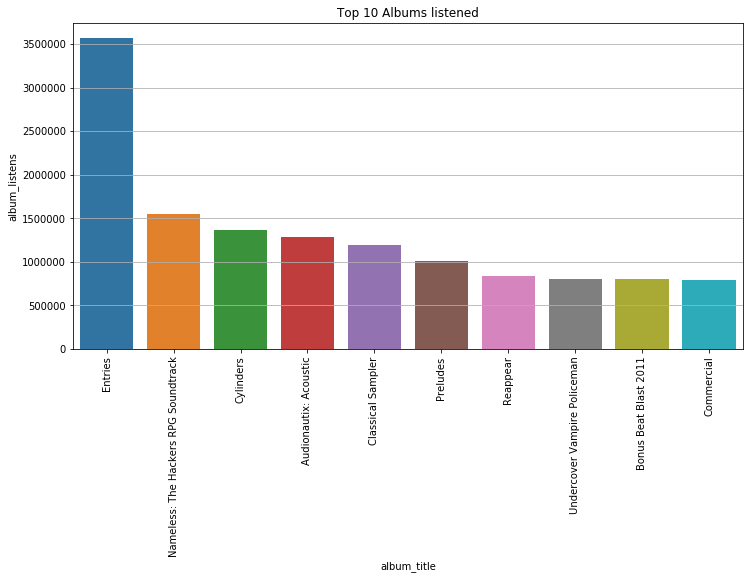

In [17]:
albums_grouped = albums_df.groupby(albums_df['album_id']) \
                          .first()[['album_title', 'album_listens']]
albums_top10 = albums_grouped.sort_values(by='album_listens', 
                                          ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.title("Top 10 Albums listened")
plt.grid()
ax = sns.barplot(x='album_title', y= 'album_listens',
                 data=albums_top10)
plt.xticks(rotation=90)


#### Top 10 Tracks

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

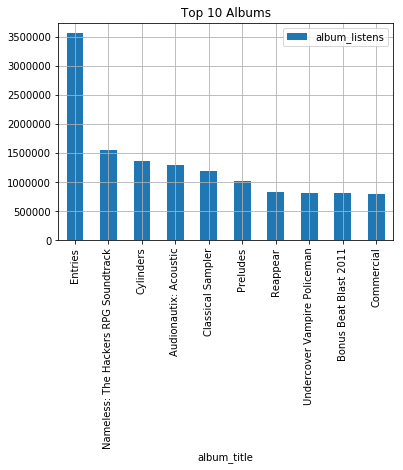

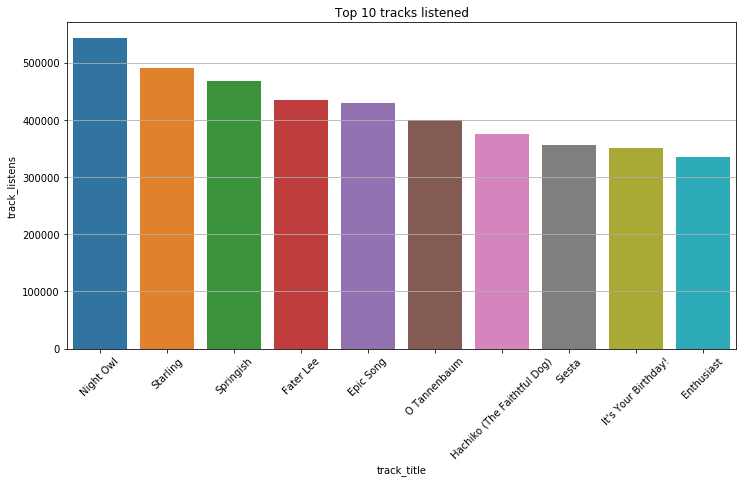

In [18]:
tracks_grouped = tracks_df.groupby(tracks_df['track_id']) \
                          .first()[['track_title', 'track_listens']]
tracks_top10 = tracks_grouped.sort_values(by='track_listens', 
                                          ascending=False).head(10)

albums_top10.plot(x='album_title', kind='bar', title="Top 10 Albums")
plt.grid()
plt.figure(figsize=(12, 6))
plt.title("Top 10 tracks listened")
plt.grid()
ax = sns.barplot(x='track_title', y= 'track_listens',
                 data=tracks_top10)
plt.xticks(rotation=45)


#### Relation between danceability and duration of the song

In [19]:
tracks_df.insert(loc=15, column='track_duration_minutes',
                 value=(tracks_df['track_duration'] / 60))

tracks_df['track_duration_minutes'] = pd.to_numeric( \
                                            tracks_df['track_duration_minutes'])


/anaconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


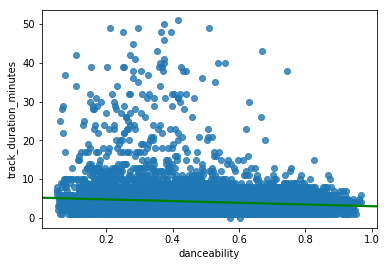

In [20]:
tracks_df['track_duration_minutes'] = tracks_df['track_duration_minutes'] \
                                                .apply(lambda x : np.rint(x))
sns.regplot(x='danceability', y='track_duration_minutes',
            data=tracks_df, ci=95, 
            line_kws = {'color': 'green'})


In [21]:
tracks_df.head()


,track_id,track_title,track_duration,artist_id,album_id,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability,energy,valence,song_currency,song_hotness,track_duration_minutes
0,2,Food,168,1,1,Hip-Hop,[21],en,1293.0,[],0.675894,0.634476,0.576661,0.000000,0.000000,3.0
1,3,Electric Ave,237,1,1,Hip-Hop,[21],en,514.0,[],0.528643,0.817461,0.269240,0.000000,0.000000,4.0
2,5,This World,206,1,1,Hip-Hop,[21],en,1151.0,[],0.745566,0.701470,0.621661,0.000000,0.000000,3.0
3,10,Freeway,161,6,6,Pop,[10],en,50135.0,[],0.658179,0.924525,0.963590,0.005158,0.354516,3.0
4,134,Street Music,207,1,1,Hip-Hop,[21],en,943.0,[],0.513238,0.560410,0.894072,0.000000,0.000000,3.0


In [22]:
spearman_coeff = stats.spearmanr(tracks_df['danceability'], 
                                 tracks_df['track_duration_minutes'])
spearman_coeff


SpearmanrResult(correlation=nan, pvalue=nan)

#### Relation between valence and other variables

Valence refers to the degree of positive or negative emotions one perceives from a song. We'll try to find some relations between such varible and others.
Relation between track_listens and valence

/anaconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


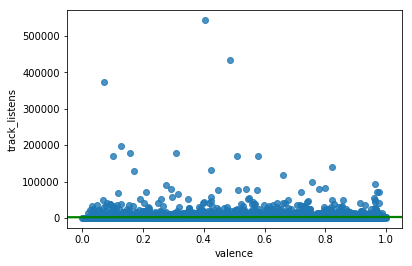

In [23]:
sns.regplot(x='valence', y='track_listens',
            data=tracks_df, ci=95, 
            line_kws ={'color': 'green'})


As seen in the plot, it is difficult to find a relationships between the valence of the song and the number of listens. We also tried to find relation between valence and energy, or valence and danceability and we found that such relationships are highly variable and do not show any dependance.

Mean value of valence per genre

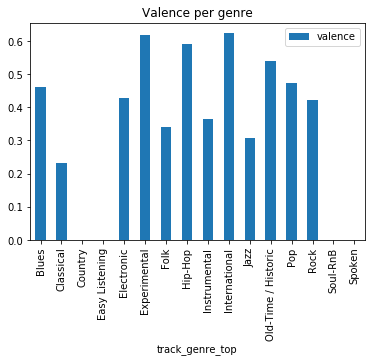

In [24]:
genre_valence = tracks_df.groupby('track_genre_top', 
                                  as_index=False)['valence'].mean()
genre_valence.plot(x='track_genre_top', kind='bar', 
                   title='Valence per genre')


In [25]:
track_album = tracks_df.merge(albums_df, left_on='album_id',
                              right_on='album_id')

genre_year = track_album[['track_genre_top', 'album_date_released']]
genre_year.insert(loc=2, column='album_released_year',
                  value=(genre_year['album_date_released'].dt.year))
genre_year.head()


,track_genre_top,album_date_released,album_released_year
0,Hip-Hop,2009-01-05,2009.0
1,Hip-Hop,2009-01-05,2009.0
2,Hip-Hop,2009-01-05,2009.0
3,Hip-Hop,2009-01-05,2009.0
4,Hip-Hop,2009-01-05,2009.0


In [26]:
top_genre = genre_year.groupby(genre_year['track_genre_top']).size()

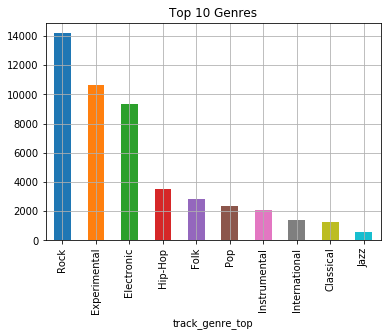

In [27]:
top_genre_sorted = top_genre.sort_values(ascending=False).head(10)
top_genre_sorted.plot(kind='bar', title="Top 10 Genres")
plt.grid()


In [28]:
track_album.sort_values(by='album_date_released', ascending=False)


,track_id,track_title,track_duration,artist_id,album_id,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability,energy,valence,song_currency,song_hotness,track_duration_minutes,album_date_created,album_date_released,album_title,album_listens
78724,116490,Transit,143,19461,17932,Instrumental,"[18, 1235]",NaN,3845.0,[],NaN,NaN,NaN,NaN,NaN,2.0,2015-03-16 14:45:09,2021-03-01,Grey River,18090.0
78723,116489,Tossed,186,19461,17932,Instrumental,"[18, 1235]",NaN,3185.0,[],NaN,NaN,NaN,NaN,NaN,3.0,2015-03-16 14:45:09,2021-03-01,Grey River,18090.0
78722,116488,Slider,132,19461,17932,Instrumental,"[18, 1235]",NaN,3227.0,[],NaN,NaN,NaN,NaN,NaN,2.0,2015-03-16 14:45:09,2021-03-01,Grey River,18090.0
78721,116487,Scraper,243,19461,17932,Instrumental,"[18, 1235]",NaN,2566.0,[],NaN,NaN,NaN,NaN,NaN,4.0,2015-03-16 14:45:09,2021-03-01,Grey River,18090.0
78725,116491,Wistful,84,19461,17932,Instrumental,"[18, 1235]",NaN,5267.0,[],NaN,NaN,NaN,NaN,NaN,1.0,2015-03-16 14:45:09,2021-03-01,Grey River,18090.0
105079,152691,That's Untrue,208,24095,22660,NaN,"[10, 137, 311]",NaN,215.0,[],NaN,NaN,NaN,NaN,NaN,3.0,2017-02-17 20:02:54,2017-12-21,Fum,4723.0
105081,152693,Slight Of Hand,372,24095,22660,NaN,"[10, 137, 311]",NaN,311.0,[],NaN,NaN,NaN,NaN,NaN,6.0,2017-02-17 20:02:54,2017-12-21,Fum,4723.0
105080,152692,July,168,24095,22660,NaN,"[10, 137, 311]",NaN,411.0,[],NaN,NaN,NaN,NaN,NaN,3.0,2017-02-17 20:02:54,2017-12-21,Fum,4723.0
105078,152690,Happy As An Ant,223,24095,22660,NaN,"[10, 137, 311]",NaN,931.0,[],NaN,NaN,NaN,NaN,NaN,4.0,2017-02-17 20:02:54,2017-12-21,Fum,4723.0
105070,152682,High Five,269,24095,22660,NaN,"[10, 137, 311]",NaN,707.0,[],NaN,NaN,NaN,NaN,NaN,4.0,2017-02-17 20:02:54,2017-12-21,Fum,4723.0


In [29]:
track_album.sort_values(by='album_date_created')


,track_id,track_title,track_duration,artist_id,album_id,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability,energy,valence,song_currency,song_hotness,track_duration_minutes,album_date_created,album_date_released,album_title,album_listens
0,2,Food,168,1,1,Hip-Hop,[21],en,1293.0,[],0.675894,0.634476,0.576661,0.000000,0.000000,3.0,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
1,3,Electric Ave,237,1,1,Hip-Hop,[21],en,514.0,[],0.528643,0.817461,0.269240,0.000000,0.000000,4.0,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
2,5,This World,206,1,1,Hip-Hop,[21],en,1151.0,[],0.745566,0.701470,0.621661,0.000000,0.000000,3.0,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
3,134,Street Music,207,1,1,Hip-Hop,[21],en,943.0,[],0.513238,0.560410,0.894072,0.000000,0.000000,3.0,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
4,10666,Hangloose,266,1,1,Hip-Hop,[21],en,929.0,[],0.543760,0.528764,0.800948,0.000000,0.000000,4.0,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
5,10815,CYCLE,151,1,1,Hip-Hop,[21],en,1205.0,[],0.677013,0.520308,0.727732,0.000000,0.000000,3.0,2008-11-26 01:44:45,2009-01-05,AWOL - A Way Of Life,6073.0
10841,42276,Know what I Mean,181,4,4,Pop,[10],NaN,379.0,[],0.419398,0.130590,0.213598,0.000000,0.000000,3.0,2008-11-26 01:45:05,2009-01-06,Niris,2710.0
10842,20,Spiritual Level,311,4,4,NaN,"[76, 103]",en,361.0,[],NaN,NaN,NaN,NaN,NaN,5.0,2008-11-26 01:45:05,2009-01-06,Niris,2710.0
10843,26,Where is your Love?,181,4,4,NaN,"[76, 103]",en,193.0,[],NaN,NaN,NaN,NaN,NaN,3.0,2008-11-26 01:45:05,2009-01-06,Niris,2710.0
10844,30,Too Happy,174,4,4,NaN,"[76, 103]",en,612.0,[],NaN,NaN,NaN,NaN,NaN,3.0,2008-11-26 01:45:05,2009-01-06,Niris,2710.0


### B) Loading and analyzing of Sentiment140

In [30]:
tweets_col_names=['sentiment', 'ID', 'Date',
                  'user', 'text']

tweets_dtypes = {'sentiment': int, 'ID': int, 
                 'Date': str, 'user': str,
                 'text': str }

tweets_df = pd.read_csv(DATA_DIR + 'tweets.csv', names=tweets_col_names,
                        dtype=tweets_dtypes, usecols=[0, 1, 2, 4, 5], 
                        encoding='latin1')


### C) Find relationships between both datasets

The main purpose of this part is to analyze the data of the tweets we downloaded from kaggle, which are already labeled as positive or negative and we can use to train the model of the project. 

First we will show how many tweets are in our data set and understand the values of the column

In [31]:
tweets_df.head()


,sentiment,ID,Date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


As you can observe we have the Sentiment (0 for negative, 2 for neutral and 4 for positive).
We have the ID of the tweet, date of the tweet, user and text on the tweet.

To find out if the idea of the project is feasible we depend on the quantity of how many tweets have links of songs, and because the data set we will use is FMA (with data from echonest, previous spotify) complemented with spotify we will search for this keyword, as all the link related to music should have it

In [32]:
f1 = tweets_df[tweets_df.text.str.contains('Spotify')]
f2 = tweets_df[tweets_df.text.str.contains('spotify')]
tweets_spotify = pd.concat([f1,f2])
num_tweets_spotify = tweets_spotify.count()
print('# Tweets that have Spotify on the text: {}'.format(num_tweets_spotify[0]))


# Tweets that have Spotify on the text: 281


In [33]:
num_tweets_total=tweets_df.count()
print('Total # of tweets: {}'.format(num_tweets_total[0]))


Total # of tweets: 1600000


In [34]:
tweets_spotify_pergentage = num_tweets_spotify[0]*100/num_tweets_total[0]
print('% tweets with Spotify on the text: {}'.format(tweets_spotify_pergentage))


% tweets with Spotify on the text: 0.0175625


##### We have less than 0.017% of tweets that relate to a song, therefore we conclude that there is not enough data on our training data set to have a confident model. Because the previous aproach was not feasible, we decide to work with the music data set and related to an important event of the last decade to analyze if/how the music played a roll on this event.

### D) Redefine Project Scope

As we can see on the music dataset, most of it is from artist in the US, and one of the biggest events in the last decade is the election of the United States of 2016 when Donald Trump was elected as president.
With this in mind the new research question is the following:
##### By analyzing the information of the music data set since 2012-2016, find the relation that the music may have had on this event, analyzing the top genre of that period, top tracks, and most important the valence and energy of the songs to try to find out how people of the US fell in that specific time

##### Then the next approach will be to compare this data with information we will obtain trhought the API spotify wit music records since end of 2016, and try to find how people feel on this period. And if posible provide a prediction of what kind of music (genre, energy, valence) people of the US will listen in the following years.

Elections of trump were on november 2016 so we will have pre-trump period with 5 years of music data

In [35]:
post_2012 = track_album.album_date_created.dt.year >= 2012
pre_2016 = track_album.album_date_created.dt.year <= 2016

pre_trump = track_album[post_2012 & pre_2016]


In [36]:
pre_trump.album_date_created.head()


13220   2012-01-03 15:57:12
13221   2012-01-03 15:57:12
13222   2012-01-03 15:57:12
13223   2012-01-03 15:57:12
13224   2012-01-03 15:57:12
Name: album_date_created, dtype: datetime64[ns]

In [37]:
pre_trump


,track_id,track_title,track_duration,artist_id,album_id,track_genre_top,track_genres_all,track_language,track_listens,track_tags,danceability,energy,valence,song_currency,song_hotness,track_duration_minutes,album_date_created,album_date_released,album_title,album_listens
13220,58340,Hurt,267,12631,10762,NaN,"[10, 17]",NaN,2848.0,[],0.674982,0.238244,0.252785,0.000018,0.043313,4.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13221,58342,Give and Take,331,12633,10762,NaN,"[10, 17, 66]",NaN,1680.0,[],0.495365,0.277979,0.328873,0.000071,0.000000,6.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13222,58346,Caroline,240,12637,10762,NaN,"[10, 12]",NaN,8565.0,[],0.300588,0.953663,0.330956,0.000110,0.120757,4.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13223,58335,Han Solo,215,12627,10762,NaN,"[19, 25]",NaN,4655.0,[],NaN,NaN,NaN,NaN,NaN,4.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13224,58336,"Smile For Me, Sun",233,9529,10762,NaN,"[4, 15, 107]",NaN,1847.0,[],NaN,NaN,NaN,NaN,NaN,4.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13225,58337,You Shall Not Pass,205,12628,10762,NaN,"[10, 12, 25]",NaN,949.0,[],NaN,NaN,NaN,NaN,NaN,3.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13226,58338,Take me down,264,12629,10762,NaN,"[10, 17]",NaN,969.0,[],NaN,NaN,NaN,NaN,NaN,4.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13227,58339,These Things We Can't Repair,173,12630,10762,NaN,"[10, 12, 17]",NaN,1175.0,[],NaN,NaN,NaN,NaN,NaN,3.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13228,58341,Oh Wee,225,12632,10762,Electronic,[495],NaN,51607.0,[],NaN,NaN,NaN,NaN,NaN,4.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0
13229,58343,Sick Like That,192,12634,10762,Electronic,"[15, 181]",NaN,1513.0,[],NaN,NaN,NaN,NaN,NaN,3.0,2012-01-03 15:57:12,2011-12-31,FrostWire Creative Commons Mixtape 2 Side B,68076.0


Top 10 tracks

/anaconda3/envs/ada/lib/python3.6/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


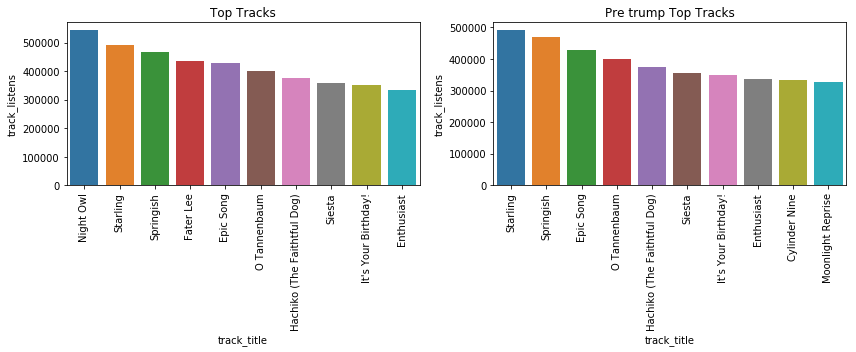

In [38]:
pre_trump_grouped = pre_trump.groupby(tracks_df['track_id']) \
                          .first()[['track_title', 
                                    'track_listens']]
pre_trump_tracks_top10 = pre_trump_grouped.sort_values(by='track_listens', 
                                                       ascending=False).head(10)


fig, axs = plt.subplots(ncols=2, constrained_layout=True, 
                        figsize=(12,5))

f1=sns.barplot(x='track_title', y= 'track_listens', 
               data=tracks_top10, ax=axs[0])
f1.set_xticklabels(f1.get_xticklabels(), rotation=90)
f1.set_title("Top Tracks")

f2=sns.barplot(x='track_title', y='track_listens',
               data=pre_trump_tracks_top10, ax=axs[1])
f2.set_xticklabels(f2.get_xticklabels(), rotation=90)
f2.set_title("Pre trump Top Tracks")
fig.tight_layout()
plt.show()


/anaconda3/envs/ada/lib/python3.6/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


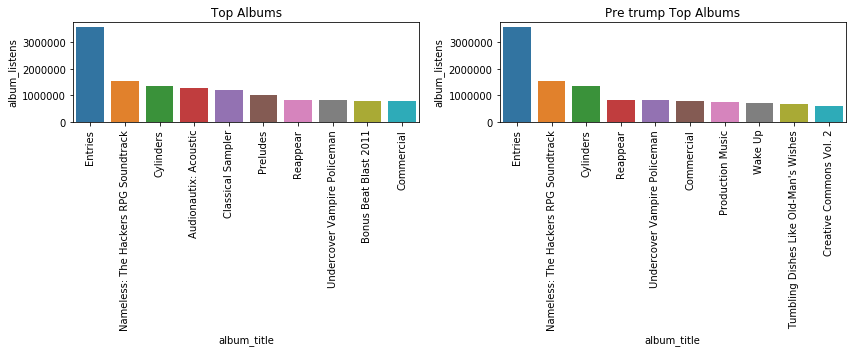

In [39]:
pre_trump_albums_grouped = pre_trump.groupby(pre_trump['album_id']) \
                          .first()[['album_title', 
                                    'album_listens']]
pre_trump_albums_top10 = pre_trump_albums_grouped.sort_values(by='album_listens', 
                                                              ascending=False).head(10)

fig, axs = plt.subplots(ncols=2, constrained_layout=True,
                        figsize=(12,5))

f1=sns.barplot(x='album_title', y= 'album_listens',
               data=albums_top10, ax=axs[0])
f1.set_xticklabels(f1.get_xticklabels(), rotation=90)
f1.set_title("Top Albums")

f2=sns.barplot(x='album_title', y='album_listens',
               data=pre_trump_albums_top10, ax=axs[1])
f2.set_xticklabels(f2.get_xticklabels(), rotation=90)
f2.set_title("Pre trump Top Albums")
fig.tight_layout()
plt.show()
